In [1]:
import numpy as np
import cv2
import h5py
import matplotlib.pyplot as plt
# from deepposekit import VideoReader, KMeansSampler
from dpk_annotator import VideoReader, KMeansSampler
import tqdm
import glob

from os.path import expanduser
home = expanduser("~")

# A note on image resolutions

Currently DeepPoseKit only supports image resolutions that can be repeatedly divided by 2. For example, all of these values are valid image resolutions for either height or width:

In [2]:
exp = np.arange(1,12)
exp = 2**exp

print(1*exp)
print(3*exp)
print(5*exp)
print(7*exp)
print(11*exp)

[   2    4    8   16   32   64  128  256  512 1024 2048]
[   6   12   24   48   96  192  384  768 1536 3072 6144]
[   10    20    40    80   160   320   640  1280  2560  5120 10240]
[   14    28    56   112   224   448   896  1792  3584  7168 14336]
[   22    44    88   176   352   704  1408  2816  5632 11264 22528]


Images that do not match these resolutions must be manually resized, cropped, or padded. We are working to add automated image size adjustments.

# Open a video

In [3]:
# use glob to get the path(s) of the video(s)
videos = glob.glob(home + '/deepposekit-data/datasets/fly/*.avi')
videos

['/Users/jake/deepposekit-data/datasets/fly/video.avi']

In [4]:
reader = VideoReader(videos[0], batch_size=100, gray=True)
frame = reader.read() # read a single frame
reader.close()

True

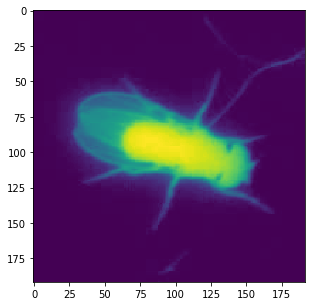

In [5]:
plt.figure(figsize=(5,5))
plt.imshow(frame[...,0])
plt.show()

# Save an image
You must save an image for initializing the annotation skeleton later

In [6]:
cv2.imwrite(home + '/deepposekit-data/datasets/fly/skeleton_image.png', frame)

True

# Sample video frames
Sample frames randomly from a video and hold them in memory

In [7]:
reader = VideoReader(videos[0], batch_size=100, gray=True)

sampled_frames = []
for idx in tqdm.tqdm(range(len(reader)-1)):
    batch = reader[idx]
    random_sample = batch[np.random.choice(batch.shape[0], 10, replace=False)]
    sampled_frames.append(random_sample)
reader.close()

sampled_frames = np.concatenate(sampled_frames)

100%|██████████| 337/337 [00:04<00:00, 75.11it/s]


# Apply k-means to reduce correlation

In [8]:
kmeans = KMeansSampler(n_clusters=10, max_iter=1000, n_init=10, batch_size=100, verbose=True)
kmeans.fit(sampled_frames)

Init 1/10 with method: k-means++
Inertia for init 1/10: 2595327547.619884
Init 2/10 with method: k-means++
Inertia for init 2/10: 2637214238.638162
Init 3/10 with method: k-means++
Inertia for init 3/10: 2666236869.537366
Init 4/10 with method: k-means++
Inertia for init 4/10: 2833080780.505448
Init 5/10 with method: k-means++
Inertia for init 5/10: 2645706176.637538
Init 6/10 with method: k-means++
Inertia for init 6/10: 2697988722.917869
Init 7/10 with method: k-means++
Inertia for init 7/10: 2591887590.185157
Init 8/10 with method: k-means++
Inertia for init 8/10: 2662413856.468967
Init 9/10 with method: k-means++
Inertia for init 9/10: 2634769156.756648
Init 10/10 with method: k-means++
Inertia for init 10/10: 2700916659.927626
Minibatch iteration 1/34000: mean batch inertia: 8577036.130556, ewa inertia: 8577036.130556 
Minibatch iteration 2/34000: mean batch inertia: 9407663.240163, ewa inertia: 8626316.884612 
Minibatch iteration 3/34000: mean batch inertia: 10184181.970381, ewa 

KMeansSampler(batch_size=100, compute_labels=True, init='k-means++',
       init_size=None, max_iter=1000, max_no_improvement=10, n_clusters=10,
       n_init=10, random_state=None, reassignment_ratio=0.01, tol=0.0,
       verbose=True)

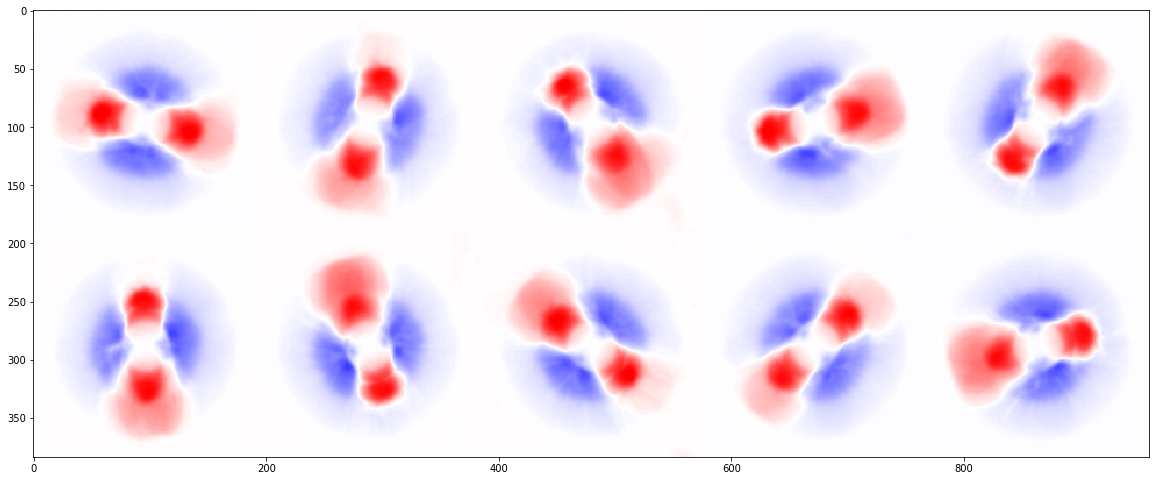

In [9]:
kmeans.plot_centers(n_rows=2)
plt.show()

In [10]:
images, labels = kmeans.sample_data(sampled_frames, n_samples_per_label=10)
images.shape

Computing label assignment and total inertia
Computing label assignment and total inertia


(100, 192, 192, 1)

# Save images to hdf5 file for annotations
You can use any method for sampling images to create a numpy array with the shape (n_images, height, width, channels) and then save to a .h5 file using the next cell.

In [ ]:
with h5py.File(home + '/deepposekit-data/datasets/fly/example_annotation_set.h5', mode='w') as h5file:
    h5file.create_dataset('images', shape=images.shape, dtype=np.uint8, data=images)

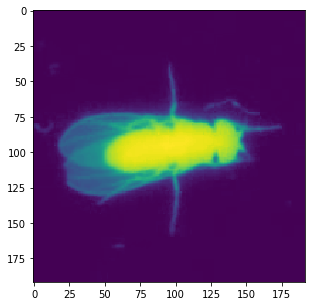

In [9]:
# Make sure the images are in the file
with h5py.File(home + '/deepposekit-data/datasets/fly/example_annotation_set.h5', mode='r') as h5file:
    h5image = h5file['images'][0]

plt.figure(figsize=(5,5))
plt.imshow(h5image[..., 0])
plt.show()

h5file.close()